In [2]:
# import libraries
import cv2
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from PIL import Image

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Read the images from Google Drive
retinal_paths = [
    '/content/drive/My Drive/retinal_21_training.tif',
    '/content/drive/My Drive/retinal_22_training.tif',
    '/content/drive/My Drive/retinal_23_training.tif',
    '/content/drive/My Drive/retinal_24_training.tif',
    '/content/drive/My Drive/retinal_25_training.tif',
]

mask_paths = [
    '/content/drive/My Drive/retinal_21_manual1.gif',
    '/content/drive/My Drive/retinal_22_manual1.gif',
    '/content/drive/My Drive/retinal_23_manual1.gif',
    '/content/drive/My Drive/retinal_24_manual1.gif',
    '/content/drive/My Drive/retinal_25_manual1.gif'
]

Mounted at /content/drive


### Custom functions (MF, FDOG, thresholding map and closing)

In [4]:
def custom_matched_filter(image, sigma, kernel_size, t=3, L=5, num_orientations=16):
    # number orientations be a multiple of 360, e.g. 8, 16, 32..
    # Convert the image to floating-point format
    image = image.astype(np.float64)

    # Create a custom kernel based on the given function f(x, y)
    def custom_kernel(x, sigma):
        m = integrate_m(sigma)
        return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-x**2 / (2 * sigma**2)) - m

    def integrate_m(sigma):
        # Numerical integration to calculate m
        a = -t * sigma
        b = t * sigma
        m, _ = quad(lambda x: (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-x**2 / (2 * sigma**2)), a, b)

        return m / (2 * t * sigma)

    # Create a 2D grid of x and y values
    x, y = np.meshgrid(np.linspace(-t * sigma, t * sigma, kernel_size), np.linspace(-L/2, L/2, kernel_size))

    # Create the kernel using the custom function
    kernel = custom_kernel(x, sigma)

    # Normalize the kernel to ensure proper weighting during filtering
    kernel /= np.sum(kernel)

    # Rotate the kernel for different orientations
    rotated_kernels = [rotate(kernel, angle, reshape=False) for angle in np.linspace(0, 180, num_orientations, endpoint=False)]

    # Apply each rotated kernel using the filter2D function and compute the average response
    average_response = np.zeros_like(image)
    for rotated_kernel in rotated_kernels:
        response = cv2.filter2D(image, cv2.CV_64F, rotated_kernel)
        average_response += response

    # Compute the average response
    average_response /= num_orientations

    return average_response

'''
    # Apply each rotated kernel using the filter2D function and keep track of the maximum response
    max_response = np.zeros_like(image)
    for rotated_kernel in rotated_kernels:
        response = cv2.filter2D(image, cv2.CV_64F, rotated_kernel)
        max_response = np.maximum(max_response, response)

    return max_response'''

'\n    # Apply each rotated kernel using the filter2D function and keep track of the maximum response\n    max_response = np.zeros_like(image)\n    for rotated_kernel in rotated_kernels:\n        response = cv2.filter2D(image, cv2.CV_64F, rotated_kernel)\n        max_response = np.maximum(max_response, response)\n\n    return max_response'

In [5]:
def custom_FDOG_filter(image, sigma, kernel_size, t=3, L=5, num_orientations=16):
    # Convert the image to floating-point format
    image = image.astype(np.float64)

    # Create a custom kernel based on the given function f(x, y)
    def custom_kernel(x, sigma):
        return (-x / (np.sqrt(2 * np.pi) * sigma**3)) * np.exp(-x**2 / (2 * sigma**2))

    # Create a 2D grid of x and y values
    x, y = np.meshgrid(np.linspace(-t * sigma, t * sigma, kernel_size), np.linspace(-L/2, L/2, kernel_size))

    # Create the kernel using the custom function
    kernel = custom_kernel(x, sigma)

    # Normalize the kernel to ensure proper weighting during filtering
    kernel /= np.sum(kernel)

    # Rotate the kernel for different orientations
    rotated_kernels = [rotate(kernel, angle, reshape=False) for angle in np.linspace(0, 180, num_orientations, endpoint=False)]

    # Apply each rotated kernel using the filter2D function
    responses = [cv2.filter2D(image, cv2.CV_64F, rotated_kernel) for rotated_kernel in rotated_kernels]

    # Take the average response at each pixel position across all orientations
    combined_response = np.mean(responses, axis=0)

    return combined_response
'''
    # Take the maximum response at each pixel position across all orientations
    combined_response = np.max(responses, axis=0)

    return combined_response'''

'\n    # Take the maximum response at each pixel position across all orientations\n    combined_response = np.max(responses, axis=0)\n\n    return combined_response'

In [6]:
def threshold_map(H, D, c=2.3, W=31):
    # Apply a 31x31 mean filter on the input response map D
    Dm = cv2.blur(D, (W, W)) # tried tweaking it

    # Normalize Dm
    Dm_ = Dm / np.max(Dm)

    # Calculate the mean pixel values miu_H of the input response map H
    miu_H = np.mean(H)

    # Calculate the threshold map T
    T = (1 + Dm_) * (c * miu_H)

    # Apply the threshold map on H to obtain the result map MH
    MH = np.zeros_like(H)
    MH[H >= T] = 1

    return MH

In [7]:
def perform_closing(binary_image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    return closed_image

### The main function that prints all the results and parameter tuning (with closing)

In [50]:
def main_function(i, c_tune=0.4, W_tune=31, Rot_tune=16):
    rgb_retinal_image = cv2.imread(retinal_paths[i], cv2.IMREAD_COLOR)

    # Convert RGB image to grayscale
    gray_retinal_image = cv2.cvtColor(rgb_retinal_image, cv2.COLOR_BGR2GRAY)

    # Read the mask
    mask_org = Image.open(mask_paths[i])
    # Convert to grayscale
    mask_gray = mask_org.convert('L')
    # Make it binary
    mask_binary_pil = mask_gray.point(lambda x: 0 if x < 128 else 1, '1')

    # Convert binary mask to NumPy array
    mask_binary = np.array(mask_binary_pil)

    # wide
    # Read the image
    image = gray_retinal_image

    # Apply median filtering to reduce noise
    image = cv2.medianBlur(image, 3)  # You can adjust the kernel size as needed, it will also make the thin vessels disappear

    # Apply Gaussian-shaped Matched filter
    response_map_H_wide = custom_matched_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Apply first-order derivative of Gaussian filter
    response_map_D_wide = custom_FDOG_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Adaptive thresholding
    vessel_extraction_wide = threshold_map(response_map_H_wide, response_map_D_wide, c=c_tune, W=W_tune)

    # Perform closing on the binary image
    vessel_extraction_wide_closed = perform_closing(vessel_extraction_wide, kernel_size=(5, 5))  # Adjust kernel size if needed

    # Thin
    # Apply Gaussian-shaped Matched filter
    response_map_H_thin = custom_matched_filter(image, sigma=1, kernel_size = 9, L=5)

    # Apply first-order derivative of Gaussian filter
    response_map_D_thin = custom_FDOG_filter(image, sigma=1,kernel_size = 9, L=5)

    # Adaptive thresholding
    vessel_extraction_thin = threshold_map(response_map_H_thin, response_map_D_thin, c=0.4) # tried tweaking c

    # Perform closing on the binary image
    vessel_extraction_thin_closed = perform_closing(vessel_extraction_thin, kernel_size=(5, 5))  # Adjust kernel size if needed

    # vessel_extraction_thin OR vessel_extraction_wide
    result_image = cv2.bitwise_or(vessel_extraction_thin_closed, vessel_extraction_wide_closed)

    # Create a mask for the relevant content (circle with r = 100 pixels at the center)
    h, w = mask_binary.shape[:2]
    center = (w // 2, h // 2)
    radius = 250

    # Create a grid of coordinates
    y, x = np.ogrid[:h, :w]

    # Create a circular mask
    roi_mask = ((x - center[0])**2 + (y - center[1])**2 <= radius**2)

    # Crop both result_image and mask_binary based on the ROI mask
    result_image_cropped = np.copy(result_image)
    result_image_cropped[~roi_mask] = 0

    mask_binary_cropped = np.copy(mask_binary)
    mask_binary_cropped[~roi_mask] = 0

    # Calculate True Positives, False Positives, True Negatives, False Negatives within ROI
    tp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 1))
    fp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 0))
    tn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 0))
    fn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 1))

    # Calculate True Positive Rate (TPR) or Sensitivity within ROI
    tpr_roi = tp_roi / (tp_roi + fn_roi)

    # Calculate False Positive Rate (FPR) within ROI
    fpr_roi = fp_roi / (fp_roi + tn_roi)

    # Calculate accuracy within ROI
    accuracy_roi = (tp_roi + tn_roi) / (tp_roi + fp_roi + tn_roi + fn_roi)

    print(f"The image is retinal_{i+21}_traing.tif, c = {c_tune}, W = {W_tune}, Rot = {Rot_tune}.")
    print(f"Accuracy within ROI: {accuracy_roi * 100:.2f}%")
    print(f"True Positive Rate (TPR) within ROI: {tpr_roi * 100:.2f}%")
    print(f"False Positive Rate (FPR) within ROI: {fpr_roi * 100:.2f}%")
    print() # print a new line to make it more readable

In [51]:
def para_tuning():
    for i in range(5):
      for c_tune in [0.4, 1, 2]:
        main_function(i=i, c_tune=c_tune)
      for W_tune in [19, 31, 43]:
        main_function(i=i, W_tune=W_tune)
      for Rot_tune in [8, 16, 32]:
        main_function(i=i, Rot_tune=Rot_tune)

In [52]:
para_tuning()

The image is retinal_21_traing.tif, c = 0.4, W = 31, Rot = 16.
Accuracy within ROI: 94.45%
True Positive Rate (TPR) within ROI: 60.90%
False Positive Rate (FPR) within ROI: 1.12%

The image is retinal_21_traing.tif, c = 1, W = 31, Rot = 16.
Accuracy within ROI: 84.50%
True Positive Rate (TPR) within ROI: 84.25%
False Positive Rate (FPR) within ROI: 15.46%

The image is retinal_21_traing.tif, c = 2, W = 31, Rot = 16.
Accuracy within ROI: 15.34%
True Positive Rate (TPR) within ROI: 98.08%
False Positive Rate (FPR) within ROI: 95.60%

The image is retinal_21_traing.tif, c = 0.4, W = 19, Rot = 16.
Accuracy within ROI: 94.47%
True Positive Rate (TPR) within ROI: 61.27%
False Positive Rate (FPR) within ROI: 1.14%

The image is retinal_21_traing.tif, c = 0.4, W = 31, Rot = 16.
Accuracy within ROI: 94.45%
True Positive Rate (TPR) within ROI: 60.90%
False Positive Rate (FPR) within ROI: 1.12%

The image is retinal_21_traing.tif, c = 0.4, W = 43, Rot = 16.
Accuracy within ROI: 94.46%
True Positi

### The main function but without closing

In [47]:
def main_function_without_closing(i, c_tune=0.4, W_tune=31, Rot_tune=16):
    rgb_retinal_image = cv2.imread(retinal_paths[i], cv2.IMREAD_COLOR)

    # Convert RGB image to grayscale
    gray_retinal_image = cv2.cvtColor(rgb_retinal_image, cv2.COLOR_BGR2GRAY)

    # Read the mask
    mask_org = Image.open(mask_paths[i])
    # Convert to grayscale
    mask_gray = mask_org.convert('L')
    # Make it binary
    mask_binary_pil = mask_gray.point(lambda x: 0 if x < 128 else 1, '1')

    # Convert binary mask to NumPy array
    mask_binary = np.array(mask_binary_pil)

    # wide
    # Read the image
    image = gray_retinal_image

    # Apply median filtering to reduce noise
    image = cv2.medianBlur(image, 3)  # You can adjust the kernel size as needed, it will also make the thin vessels disappear

    # Apply Gaussian-shaped Matched filter
    response_map_H_wide = custom_matched_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Apply first-order derivative of Gaussian filter
    response_map_D_wide = custom_FDOG_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Adaptive thresholding
    vessel_extraction_wide = threshold_map(response_map_H_wide, response_map_D_wide, c=c_tune, W=W_tune)

    # Thin
    # Apply Gaussian-shaped Matched filter
    response_map_H_thin = custom_matched_filter(image, sigma=1, kernel_size = 9, L=5)

    # Apply first-order derivative of Gaussian filter
    response_map_D_thin = custom_FDOG_filter(image, sigma=1,kernel_size = 9, L=5)

    # Adaptive thresholding
    vessel_extraction_thin = threshold_map(response_map_H_thin, response_map_D_thin, c=0.4) # tried tweaking c

    # vessel_extraction_thin OR vessel_extraction_wide
    result_image = cv2.bitwise_or(vessel_extraction_thin, vessel_extraction_wide)

    # Create a mask for the relevant content (circle with r = 100 pixels at the center)
    h, w = mask_binary.shape[:2]
    center = (w // 2, h // 2)
    radius = 250

    # Create a grid of coordinates
    y, x = np.ogrid[:h, :w]

    # Create a circular mask
    roi_mask = ((x - center[0])**2 + (y - center[1])**2 <= radius**2)

    # Crop both result_image and mask_binary based on the ROI mask
    result_image_cropped = np.copy(result_image)
    result_image_cropped[~roi_mask] = 0

    mask_binary_cropped = np.copy(mask_binary)
    mask_binary_cropped[~roi_mask] = 0

    # Calculate True Positives, False Positives, True Negatives, False Negatives within ROI
    tp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 1))
    fp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 0))
    tn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 0))
    fn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 1))

    # Calculate True Positive Rate (TPR) or Sensitivity within ROI
    tpr_roi = tp_roi / (tp_roi + fn_roi)

    # Calculate False Positive Rate (FPR) within ROI
    fpr_roi = fp_roi / (fp_roi + tn_roi)

    # Calculate accuracy within ROI
    accuracy_roi = (tp_roi + tn_roi) / (tp_roi + fp_roi + tn_roi + fn_roi)

    print(f"The image is retinal_train_{i+21}.png, c = {c_tune}, W = {W_tune}, Rot = {Rot_tune}.")
    print(f"Accuracy within ROI: {accuracy_roi * 100:.2f}%")
    print(f"True Positive Rate (TPR) within ROI: {tpr_roi * 100:.2f}%")
    print(f"False Positive Rate (FPR) within ROI: {fpr_roi * 100:.2f}%")
    print() # print a new line to make it more readable

In [48]:
def para_tuning_without_closing():
    for i in range(5):
      for c_tune in [0.4, 1, 2]:
        main_function_without_closing(i=i, c_tune=c_tune)
      for W_tune in [19, 31, 43]:
        main_function_without_closing(i=i, W_tune=W_tune)
      for Rot_tune in [8, 16, 32]:
        main_function_without_closing(i=i, Rot_tune=Rot_tune)

In [49]:
para_tuning_without_closing()

The image is retinal_train_21.png, c = 0.4, W = 31, Rot = 16.
Accuracy within ROI: 94.10%
True Positive Rate (TPR) within ROI: 56.55%
False Positive Rate (FPR) within ROI: 0.93%

The image is retinal_train_21.png, c = 1, W = 31, Rot = 16.
Accuracy within ROI: 87.76%
True Positive Rate (TPR) within ROI: 77.91%
False Positive Rate (FPR) within ROI: 10.93%

The image is retinal_train_21.png, c = 2, W = 31, Rot = 16.
Accuracy within ROI: 28.18%
True Positive Rate (TPR) within ROI: 93.58%
False Positive Rate (FPR) within ROI: 80.47%

The image is retinal_train_21.png, c = 0.4, W = 19, Rot = 16.
Accuracy within ROI: 94.12%
True Positive Rate (TPR) within ROI: 56.85%
False Positive Rate (FPR) within ROI: 0.95%

The image is retinal_train_21.png, c = 0.4, W = 31, Rot = 16.
Accuracy within ROI: 94.10%
True Positive Rate (TPR) within ROI: 56.55%
False Positive Rate (FPR) within ROI: 0.93%

The image is retinal_train_21.png, c = 0.4, W = 43, Rot = 16.
Accuracy within ROI: 94.11%
True Positive Rat

### The function to plot the process images along with results

In [45]:
def main_function_with_plot(i, c_tune=0.4, W_tune=31, Rot_tune=16):
    rgb_retinal_image = cv2.imread(retinal_paths[i], cv2.IMREAD_COLOR)

    # Convert RGB image to grayscale
    gray_retinal_image = cv2.cvtColor(rgb_retinal_image, cv2.COLOR_BGR2GRAY)

    # Read the mask
    mask_org = Image.open(mask_paths[i])
    # Convert to grayscale
    mask_gray = mask_org.convert('L')
    # Make it binary
    mask_binary_pil = mask_gray.point(lambda x: 0 if x < 128 else 1, '1')

    # Convert binary mask to NumPy array
    mask_binary = np.array(mask_binary_pil)

    # wide
    # Read the image
    image = gray_retinal_image

    # Apply median filtering to reduce noise
    image = cv2.medianBlur(image, 3)  # You can adjust the kernel size as needed, it will also make the thin vessels disappear

    # Apply Gaussian-shaped Matched filter
    response_map_H_wide = custom_matched_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Apply first-order derivative of Gaussian filter
    response_map_D_wide = custom_FDOG_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Adaptive thresholding
    vessel_extraction_wide = threshold_map(response_map_H_wide, response_map_D_wide, c=c_tune, W=W_tune)

    # Perform closing on the binary image
    vessel_extraction_wide_closed = perform_closing(vessel_extraction_wide, kernel_size=(5, 5))  # Adjust kernel size if needed

    # Thin
    # Apply Gaussian-shaped Matched filter
    response_map_H_thin = custom_matched_filter(image, sigma=1, kernel_size = 9, L=5)

    # Apply first-order derivative of Gaussian filter
    response_map_D_thin = custom_FDOG_filter(image, sigma=1,kernel_size = 9, L=5)

    # Adaptive thresholding
    vessel_extraction_thin = threshold_map(response_map_H_thin, response_map_D_thin, c=0.4) # tried tweaking c

    # Perform closing on the binary image
    vessel_extraction_thin_closed = perform_closing(vessel_extraction_thin, kernel_size=(5, 5))  # Adjust kernel size if needed

    # vessel_extraction_thin OR vessel_extraction_wide
    result_image = cv2.bitwise_or(vessel_extraction_thin_closed, vessel_extraction_wide_closed)

    # Create a mask for the relevant content (circle with r = 100 pixels at the center)
    h, w = mask_binary.shape[:2]
    center = (w // 2, h // 2)
    radius = 250

    # Create a grid of coordinates
    y, x = np.ogrid[:h, :w]

    # Create a circular mask
    roi_mask = ((x - center[0])**2 + (y - center[1])**2 <= radius**2)

    # Crop both result_image and mask_binary based on the ROI mask
    result_image_cropped = np.copy(result_image)
    result_image_cropped[~roi_mask] = 0

    mask_binary_cropped = np.copy(mask_binary)
    mask_binary_cropped[~roi_mask] = 0

    # Calculate True Positives, False Positives, True Negatives, False Negatives within ROI
    tp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 1))
    fp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 0))
    tn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 0))
    fn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 1))

    # Calculate True Positive Rate (TPR) or Sensitivity within ROI
    tpr_roi = tp_roi / (tp_roi + fn_roi)

    # Calculate False Positive Rate (FPR) within ROI
    fpr_roi = fp_roi / (fp_roi + tn_roi)

    # Calculate accuracy within ROI
    accuracy_roi = (tp_roi + tn_roi) / (tp_roi + fp_roi + tn_roi + fn_roi)

    print(f"The image is retinal_{i+21}_training.tif, c = {c_tune}, W = {W_tune}, Rot = {Rot_tune}.")
    print(f"Accuracy within ROI: {accuracy_roi * 100:.2f}%")
    print(f"True Positive Rate (TPR) within ROI: {tpr_roi * 100:.2f}%")
    print(f"False Positive Rate (FPR) within ROI: {fpr_roi * 100:.2f}%")
    print() # print a new line to make it more readable

    # Display the results using matplotlib
    plt.figure(figsize=(16, 16))

    plt.subplot(4, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(4, 4, 2)
    plt.imshow(response_map_H_wide, cmap='bwr', vmin=np.min(response_map_H_wide), vmax=np.max(response_map_H_wide))
    plt.title('Response Map H-wide')

    plt.subplot(4, 4, 3)
    plt.imshow(response_map_D_wide, cmap='bwr', vmin=np.min(response_map_D_wide), vmax=np.max(response_map_D_wide))
    plt.title('Response Map D-wide')

    plt.subplot(4, 4, 4)
    plt.imshow(vessel_extraction_wide_closed, cmap='gray')
    plt.title('vessel extraction result - wide')

    plt.subplot(4, 4, 5)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(4, 4, 6)
    plt.imshow(response_map_H_thin, cmap='bwr', vmin=np.min(response_map_H_thin), vmax=np.max(response_map_H_thin))
    plt.title('Response Map H-thin')

    plt.subplot(4, 4, 7)
    plt.imshow(response_map_D_thin, cmap='bwr', vmin=np.min(response_map_D_thin), vmax=np.max(response_map_D_thin))
    plt.title('Response Map D-thin')

    plt.subplot(4, 4, 8)
    plt.imshow(vessel_extraction_thin_closed, cmap='gray')
    plt.title('vessel extraction result - thin')

    plt.subplot(4, 4, 9)
    plt.imshow(mask_binary, cmap='gray')
    plt.title('Mask-Binary')

    plt.subplot(4, 4, 10)
    plt.imshow(vessel_extraction_wide_closed, cmap='gray')
    plt.title('vessel extraction result - wide')

    plt.subplot(4, 4, 11)
    plt.imshow(vessel_extraction_thin_closed, cmap='gray')
    plt.title('vessel extraction result - thin')

    plt.subplot(4, 4, 12)
    plt.imshow(result_image, cmap='gray')
    plt.title('Result Image')

    plt.subplot(4, 4, 13)
    plt.imshow(roi_mask, cmap='gray')
    plt.title('Region of Interest Mask')

    plt.subplot(4, 4, 14)
    plt.imshow(mask_binary_cropped, cmap='gray')
    plt.title('Cropped Binary Mask')

    plt.subplot(4, 4, 15)
    plt.imshow(result_image_cropped, cmap='gray')
    plt.title('Cropped Result Image')

    plt.subplot(4, 4, 16)
    plt.imshow(result_image, cmap='gray')
    plt.title('Result Image')

    plt.show()

The image is retinal_23_training.tif, c = 0.4, W = 31, Rot = 16.
Accuracy within ROI: 93.66%
True Positive Rate (TPR) within ROI: 54.19%
False Positive Rate (FPR) within ROI: 1.85%



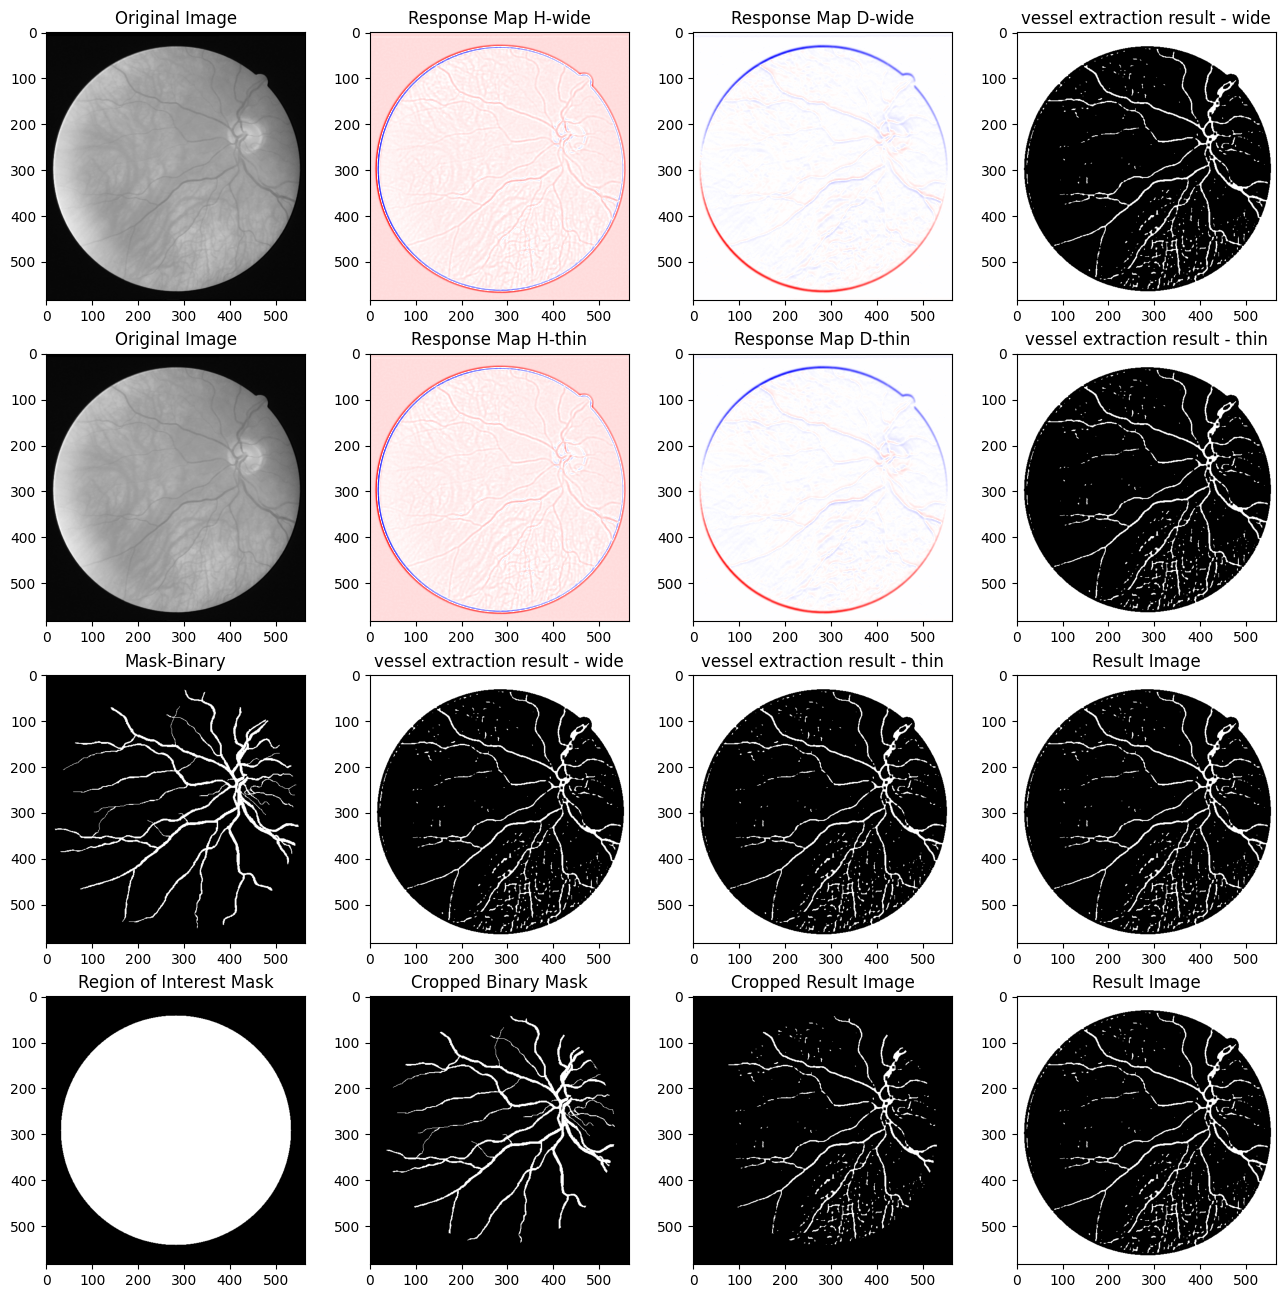

In [53]:
main_function_with_plot(i=2)

### The function to plot and compare with baseline methods

In [8]:
def binary_thresholding(image, threshold=128):
    _, binary_image = cv2.threshold(image, threshold, 1, cv2.THRESH_BINARY)
    return binary_image

def edge_detection(image, low_threshold=50, high_threshold=150):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

In [14]:
def main_function_with_plot_and_baseline(i, c_tune=0.4, W_tune=31, Rot_tune=16):
    rgb_retinal_image = cv2.imread(retinal_paths[i], cv2.IMREAD_COLOR)

    # Convert RGB image to grayscale
    gray_retinal_image = cv2.cvtColor(rgb_retinal_image, cv2.COLOR_BGR2GRAY)

    # Read the mask
    mask_org = Image.open(mask_paths[i])
    # Convert to grayscale
    mask_gray = mask_org.convert('L')
    # Make it binary
    mask_binary_pil = mask_gray.point(lambda x: 0 if x < 128 else 1, '1')

    # Convert binary mask to NumPy array
    mask_binary = np.array(mask_binary_pil)

    # Read the image
    image = gray_retinal_image

    # Apply median filtering to reduce noise
    image = cv2.medianBlur(image, 3)  # You can adjust the kernel size as needed, it will also make the thin vessels disappear

    # Thresholding method
    thresh_result = binary_thresholding(image, threshold=128)

    # Edge detection method
    edge_result = edge_detection(image, low_threshold=50, high_threshold=150)



    # MF-FDOG method
    # wide

    # Apply Gaussian-shaped Matched filter
    response_map_H_wide = custom_matched_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Apply first-order derivative of Gaussian filter
    response_map_D_wide = custom_FDOG_filter(image, sigma=2, kernel_size = 9, L=9, num_orientations = Rot_tune)

    # Adaptive thresholding
    vessel_extraction_wide = threshold_map(response_map_H_wide, response_map_D_wide, c=c_tune, W=W_tune)

    # Perform closing on the binary image
    vessel_extraction_wide_closed = perform_closing(vessel_extraction_wide, kernel_size=(5, 5))  # Adjust kernel size if needed

    # Thin
    # Apply Gaussian-shaped Matched filter
    response_map_H_thin = custom_matched_filter(image, sigma=1, kernel_size = 9, L=5)

    # Apply first-order derivative of Gaussian filter
    response_map_D_thin = custom_FDOG_filter(image, sigma=1,kernel_size = 9, L=5)

    # Adaptive thresholding
    vessel_extraction_thin = threshold_map(response_map_H_thin, response_map_D_thin, c=0.4) # tried tweaking c

    # Perform closing on the binary image
    vessel_extraction_thin_closed = perform_closing(vessel_extraction_thin, kernel_size=(5, 5))  # Adjust kernel size if needed

    # vessel_extraction_thin OR vessel_extraction_wide
    result_image = cv2.bitwise_or(vessel_extraction_thin_closed, vessel_extraction_wide_closed)

    # Create a mask for the relevant content (circle with r = 100 pixels at the center)
    h, w = mask_binary.shape[:2]
    center = (w // 2, h // 2)
    radius = 250

    # Create a grid of coordinates
    y, x = np.ogrid[:h, :w]

    # Create a circular mask
    roi_mask = ((x - center[0])**2 + (y - center[1])**2 <= radius**2)

    # Crop both result_image and mask_binary based on the ROI mask
    result_image_cropped = np.copy(result_image)
    result_image_cropped[~roi_mask] = 0

    mask_binary_cropped = np.copy(mask_binary)
    mask_binary_cropped[~roi_mask] = 0

    # Calculate True Positives, False Positives, True Negatives, False Negatives within ROI
    tp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 1))
    fp_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 1, mask_binary_cropped[roi_mask] == 0))
    tn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 0))
    fn_roi = np.sum(np.logical_and(result_image_cropped[roi_mask] == 0, mask_binary_cropped[roi_mask] == 1))

    # Calculate True Positive Rate (TPR) or Sensitivity within ROI
    tpr_roi = tp_roi / (tp_roi + fn_roi)

    # Calculate False Positive Rate (FPR) within ROI
    fpr_roi = fp_roi / (fp_roi + tn_roi)

    # Calculate accuracy within ROI
    accuracy_roi = (tp_roi + tn_roi) / (tp_roi + fp_roi + tn_roi + fn_roi)

    print(f"The image is retinal_{i+21}_training.tif, c = {c_tune}, W = {W_tune}, Rot = {Rot_tune}.")
    print(f"Accuracy within ROI: {accuracy_roi * 100:.2f}%")
    print(f"True Positive Rate (TPR) within ROI: {tpr_roi * 100:.2f}%")
    print(f"False Positive Rate (FPR) within ROI: {fpr_roi * 100:.2f}%")
    print() # print a new line to make it more readable

    # Display the results using matplotlib
    plt.figure(figsize=(16, 16))

    plt.subplot(1, 4, 1)
    plt.imshow(mask_binary, cmap='gray')
    plt.title('Mask-Binary')

    plt.subplot(1, 4, 2)
    plt.imshow(result_image_cropped, cmap='gray')
    plt.title('Cropped MF-FDOG Result')

    plt.subplot(1, 4, 3)
    plt.imshow(thresh_result, cmap='gray')
    plt.title(f'Binary Thresholding Result\nThreshold={128}')

    plt.subplot(1, 4, 4)
    plt.imshow(edge_result, cmap='gray')
    plt.title(f'Canny Edge Detection Result\nLow={50}, High={150}')


    plt.show()

The image is retinal_21_training.tif, c = 0.4, W = 31, Rot = 16.
Accuracy within ROI: 94.45%
True Positive Rate (TPR) within ROI: 60.90%
False Positive Rate (FPR) within ROI: 1.12%



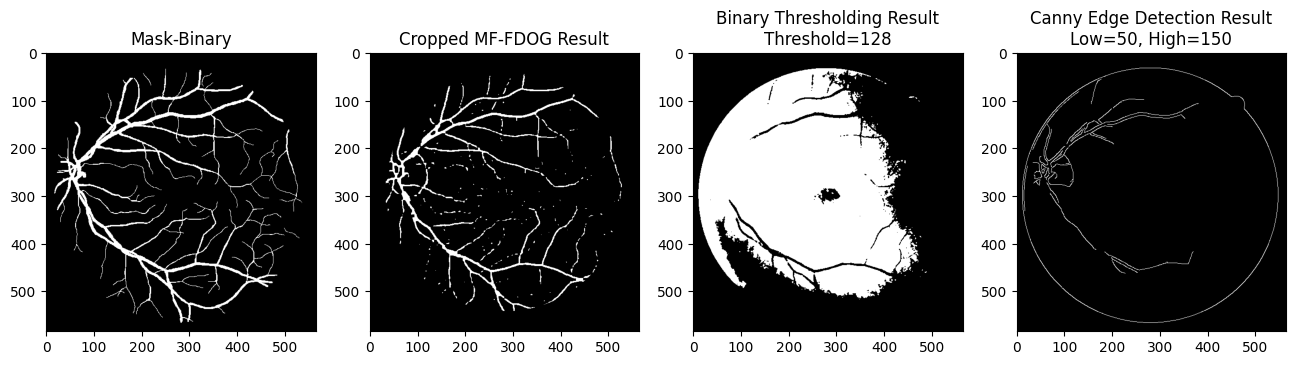

In [15]:
main_function_with_plot_and_baseline(i=0)